In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
%pylab inline
figsize(14, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_violin_hist(data, target, column):
    plt.subplot(1,2,1)
    sns.violinplot(x = target, y = column, data = data)
    plt.subplot(1,2,2)
    sns.distplot(data[data[target] == 1.0][column], color = 'green')
    sns.distplot(data[data[target] == 0.0][column], color = 'red')
    plt.show()
    
def plot_hist_discrete(data, target, column):
    #sns.factorplot(x = target, y = column, hue="smoker", data=tips, kind="bar");
    bins = data[column].nunique()
    plt.hist([data[data[target] == 1.0][column], data[data[target] == 0.0][column]], color=['g','r'], 
             alpha = 0.5, bins = bins)
    plt.title(column)
    plt.show()
    
heroes = {
    25: 'shaman',
    326: 'hunter',
    390: 'warlock',
    494: 'mage',
    612: 'druid',
    754: 'rogue',
    798: 'priest',
    981: 'paladin',
    1235: 'warrior'
}

### Reading the data from file

In [4]:
df = pd.read_csv('trainingData_tabular_chunk1.csv')

In [5]:
df.head()

,gamestate_id,decision,turn,opponent.armor,opponent.attack,opponent.hero_card_id,opponent.hp,opponent.special_skill_used,opponent.weapon_durability,opponent.crystals_all,...,player.played.hp_current,player.played.hp_max,player.hand.nOfMinions,player.hand.nOfSpells,player.hand.nOfWeapons,player.hand.nOfCards,player.hand.nOfPlayable,player.hand.attack,player.hand.crystals_cost,player.hand.hp
0,4687346,1,14,0,0,798,5,0,0,10,...,20,23,4,0,1,5,0,20,22,17
1,3270826,1,7,0,0,754,22,0,0,6,...,16,17,3,2,2,7,0,17,26,20
2,3189487,1,5,3,0,612,29,0,0,4,...,0,0,5,0,0,5,2,26,28,27
3,4098946,1,8,0,0,390,26,0,0,7,...,2,2,7,1,1,9,9,36,44,36
4,2661127,0,13,0,0,25,30,0,0,10,...,7,7,4,0,0,4,4,13,13,14


### 1. Explanatory data analysis

In [6]:
# Оцениваем hp+armor вместе
df['opponent.hp.armor'] = df['opponent.hp'] + df['opponent.armor']
df['player.hp.armor'] = df['player.hp'] + df['player.armor']

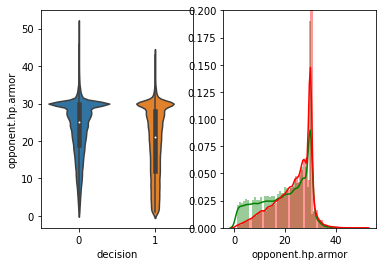

In [7]:
plot_violin_hist(df, 'decision', 'opponent.hp.armor')

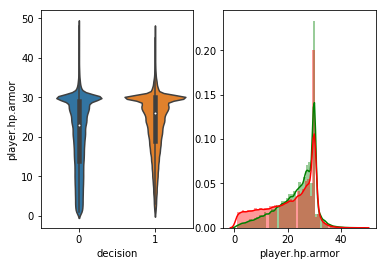

In [8]:
plot_violin_hist(df, 'decision', 'player.hp.armor')

In [9]:
df['diff.hp.armor'] = df['player.hp.armor'] - df['opponent.hp.armor']

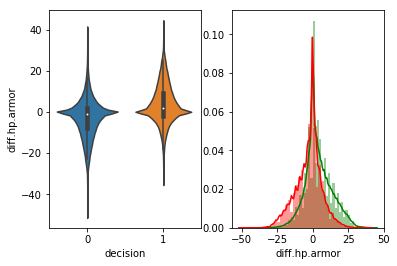

In [10]:
plot_violin_hist(df, 'decision', 'diff.hp.armor')

In [11]:
# Аналогично оцениваем разность карт в руке у игрока и оппонента
df['diff.hand_count'] = df['player.hand_count'] - df['opponent.hand_count']

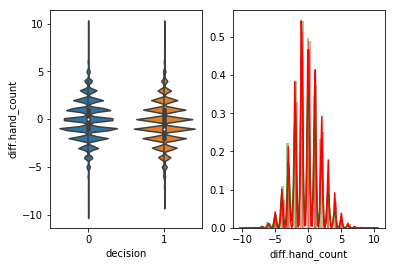

In [12]:
plot_violin_hist(df, 'decision', 'diff.hand_count')

In [13]:
# Выигрыш наступает, когда наша атака больше hp+armor противника
df['diff_attack_op_hp'] = df['player.played.attack'] - df['opponent.hp.armor']

C:\Users\Nina\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


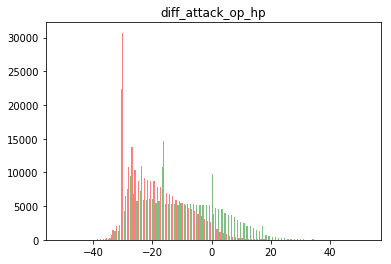

In [14]:
plot_hist_discrete(df, 'decision', 'diff_attack_op_hp')

### 2. Dividing heroes by folds

Dividing data into groups

In [15]:
dfSort = df.sort_values(by = ['player.hero_card_id', 'opponent.hero_card_id'])
heroList = list(np.unique(dfSort['player.hero_card_id']))
classes = []

In [ ]:
for i, row in dfSort.iterrows():
    for player in heroList:
        if (dfSort.at[i, 'player.hero_card_id'] == player):
            classes.append(heroList.index(player))

In [16]:
columnsDrop = ['opponent.hero_card_id', 'player.hero_card_id', 'decision', 'gamestate_id']

#### Dividing by folds

In [21]:
X = dfSort.drop(columnsDrop, 1)
y = dfSort['decision']

skf = list(StratifiedKFold(n_splits = 9).split(X, y, classes))

### 3. Learning using KNN, LR, RF and so on

#### Using KNN

In [22]:
cvs = cross_val_score(KNeighborsClassifier(n_neighbors = 7, n_jobs = 12), X, y, scoring = 'roc_auc', cv = skf)
print(cvs.mean())

0.7298077811553023


#### Using Logistic Regression

In [20]:
cvs = cross_val_score(LogisticRegression(), X, y, scoring = 'roc_auc', cv = skf)
print(cvs.mean())

0.7828678326750533


#### Using decision tree

In [23]:
cvs = cross_val_score(DecisionTreeClassifier(), X, y, scoring = 'roc_auc', cv = skf)
print(cvs.mean())

0.6237783472789947


#### Using random forest

In [24]:
cvs = cross_val_score(RandomForestClassifier(), X, y, scoring = 'roc_auc', cv = skf)
print(cvs.mean())

0.7410791132139015
